<div align="center"><b> APSERa Simulation for 2-4 GHz </b></div>


<div align="center"><b> Importing required packages </b></div>


In [5]:
#The following code is written using GlobalSkyModel and not GlobalSkyModel2016. The difference is just the units, and that can be modified anytime.

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem

%matplotlib inline

from pygsm import GlobalSkyModel
from ms_fit_joint_inf import ms_fit_inf, chisq_poly
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline



In [6]:
start_time_in_UTC = '2012-05-20 1:45:00'
n_spectra = 5
delta_t_in_hours = 1

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')
print(t)

ts = TimeSeries(time_start= '2012-05-20 1:45:00', time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)



2012-05-20 01:45:00.000
['2012-05-20 01:45:00.000' '2012-05-20 02:45:00.000'
 '2012-05-20 03:45:00.000' '2012-05-20 04:45:00.000'
 '2012-05-20 05:45:00.000']


<div align="center"><b> Definitions </b></div>


In [7]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2
f_stop = 4
No_of_Channels = 201
Channel_width = 0.01
N_SIDE = 16
T_hot = 3730
T_cold = 2730         #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = 13.067439
longitude = 80.237617       #Latitude and longitude in degrees
altitude = 0            #Altitude in meters
alpha = 0.0065            #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 2.7e10
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R

#Beam definition
def beam_def(freq, az, alt):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))
    
print(Time_in_UTC[0])
    

2012-05-20 01:45:00.000


<div align="center"><b> Getting maps, calculating CMB intensity </b></div>


In [8]:
freq_split = (np.array_split(freqs, 6))
gsm = GlobalSkyModel(freq_unit='GHz')

#The gsm values can be extracted in a single line of code. I broke into 6 lines and joined again, as my system can't handle! 

spectrum1 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[0]))), N_SIDE)
spectrum2 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[1]))), N_SIDE)
spectrum3 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[2]))), N_SIDE)
spectrum4 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[3]))), N_SIDE)
spectrum5 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[4]))), N_SIDE)
spectrum6 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[5]))), N_SIDE)



map_1 = (np.concatenate((spectrum1, spectrum2, spectrum3, spectrum4,spectrum5, spectrum6), axis=0))

#The map is in antennae Temp units. The below line is to convert it into same power units 
map_1 = 2*k*map_1         # = 2kT (Still a bit confused if this is correct)

print("Got the map!")

CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
CMB_Int_RJ = CMB_Int * c*c/ (1e+18* freqs**2)

print("Got CMB Int!")

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold



Got the map!
Got CMB Int!


<div align="center"><b> Getting recombination lines </b></div>


In [9]:
NPIX = hp.nside2npix(N_SIDE)
df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)

#Converting into same power units as CMB and rec line 
Rec_int = Rec_int *  c*c/ (1e+18* freqs**2)


/tmp/ipykernel_10949/3424313489.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)


<div align="center"><b> Getting temperature values after calibration </b></div>


No. of spectra got =  1
No. of spectra got =  2
No. of spectra got =  3
No. of spectra got =  4
No. of spectra got =  5


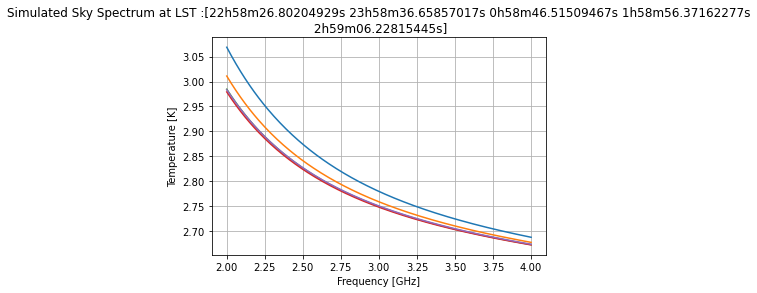

In [10]:
k = 0
while k<n_spectra:
    i=1
    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[k], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
    
    
    
        j=0
        while j< No_of_Channels:
            cwt = beam_def(freqs[j],equi.az.value, new_alt)
        
            if (cwt>0):     #Adding all 3 intensities
                Power = CMB_Int_RJ[j] + map_1[j][i-1] + Rec_int[j]
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
                cross_real[j] = cross_real[j] + cwt*final_temp
                sumwt[j] = sumwt[j]+ cwt
            
            j = j+1
        
        
        i = i+1

    
    i=0    
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        
    sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)    
    array = np.random.normal(0,1,No_of_Channels)

    cross_real = cross_real + array*sigma
    cross_imag = cross_imag + array*sigma
    
    spectra[k] = cross_real
    spectra_cross_imag[k] = cross_imag
    
    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = [0]*No_of_Channels
    
    print("No. of spectra got = ", k+1)
    
    k = k+1

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
    

i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()




In [17]:
with open("Data1.txt",'w') as fh:
    fh.write(repr(spectra))
fh.close()

(24, 201)


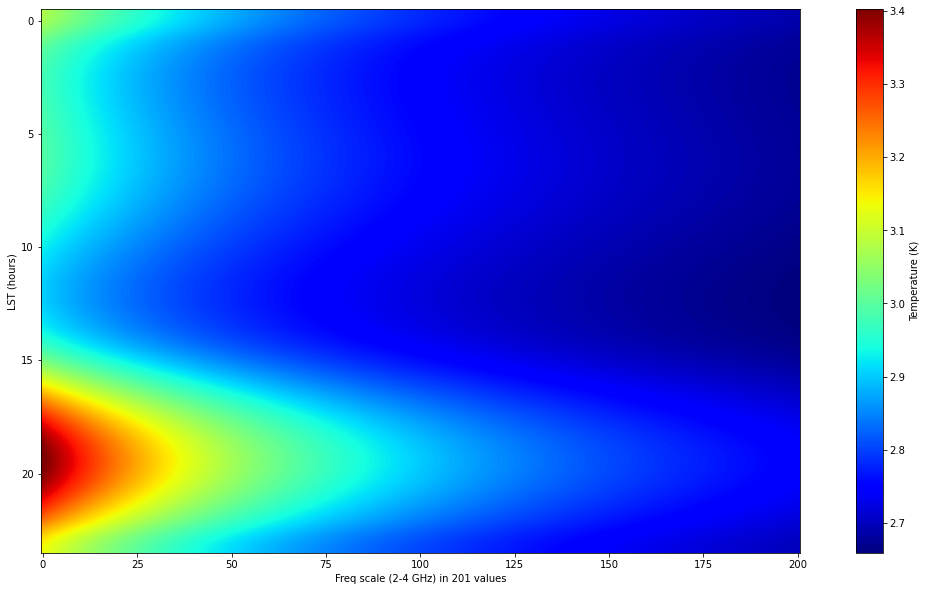

In [12]:
x = freqs
Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
y = np.array(lst)
z = np.array(spectra)

print(z.shape)

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.imshow(z,cmap= 'jet',aspect='6',interpolation= 'spline16')
bar = plt.colorbar()
plt.xlabel('Freq scale (2-4 GHz) in 201 values')
plt.ylabel('LST (hours)')
bar.set_label('Temperature (K)')
plt.show()

In [24]:
#Added this cell code above!


# #Adding thermal noise to the final spectrum    
# #For the total power radiometer:
# sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)

# #Uncomment for checking seperate intensities    
# #sigma1 = (np.array(cross_real1) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)


# #Generating array of random numbers(of length = No.of channels) with mean =0, std = 1 
# array = np.random.normal(0,1,No_of_Channels)

# cross_real = cross_real + array*sigma
# cross_imag = cross_imag + array*sigma

# #Uncomment for checking seperate intensities   
# # cross_real1 = cross_real1 + array*sigma1
# # cross_imag1 = cross_imag1 + array*sigma1



In [55]:
#Added this cell code above! 

#Obs = ephem.Observer()
# t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
# lst = t.sidereal_time('apparent')

  
# plt.plot(freqs, spectra, color = 'orange')
# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [K]')
# plt.title('Simulated Sky Spectrum at LST :%s'%lst)
# plt.grid()
# plt.show()


# plt.plot(freqs, spectra_cross_imag, color = 'orange')
# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [K]')
# plt.title('Simulated Sky Spectrum for noise integration time of : %.2E seconds'%Noise_int_time)
# plt.grid()
# plt.show()

<div align="center"><b> Fitting with Maxsmooth function </b></div>


/tmp/ipykernel_10949/2157888131.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)


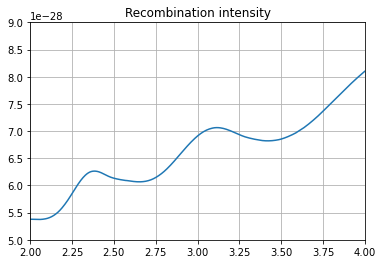

In [29]:
# #Trying with one cross_real value


# # #Using maxsmooth function
# result = smooth((freqs), spectra[0], 14)
# C = result.y_fit

# # print(C)

# #Uncomment for checking seperate intensities 
# #result1 = smooth(freqs, cross_real1, 14)
# #D = result1.y_fit

# plt.plot(freqs,spectra[0]- C, color = 'black')
# #plt.plot(freqs, A)
# #plt.ylim(-0.00004,0.00004)
# #plt.plot(freqs, cross_real1- D, color = 'blue')
# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [K]')
# plt.title('Simulated Sky Spectrum residual')
# plt.grid()
# plt.show()

df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
plt.plot((df['Frequency']), (df['Intensity']))
plt.title('Recombination intensity')
plt.xlim([2,4])
plt.ylim([5e-28,9e-28])
plt.grid()
plt.show()

<div align="center"><b> Fitting with MS_fit function </b></div>


+------------------+--------------------+
|    Parameter     |       Value        |
+------------------+--------------------+
|       flag       |    201 elements    |
|      error       |    201 elements    |
|       xtol       |       1e-06        |
|       ftol       |       1e-06        |
|      domain      |      log_log       |
|     maxiter      |      100000.0      |
|      maxfev      |      100000.0      |
|       algo       |    Nelder-Mead     |
|      norder      |         8          |
|       temp       |        0.1         |
|     stepsize     |        0.1         |
|      niter       |         1          |
| basin_iter_loops |         10         |
|       xmin       |        2.0         |
|       xmax       |        4.0         |
|     rescale      |        True        |
|       seed       |         1          |
|     additive     |        True        |
|      joint       |       False        |
|      signal      |      [False]       |
|     add_ini      |        0.0   

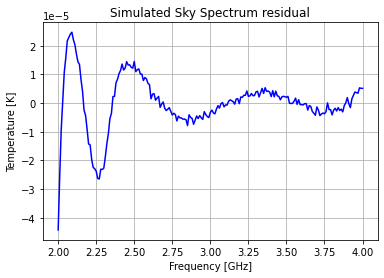

In [13]:
#Trying with once cross_real value

Res = (ms_fit_inf(freqs, spectra[0], norder = 8, domain='log_log'))
#Res1 = (ms_fit(freqs, cross_real1, norder = 8, error = cross_imag1))

#Res[5] gives the residual value after fitting. Res[5] array and Res[4] has only 200 values, while input 201 values. Not sure why. For plotting,I just added one term 
Res5 = Res[5]
Res5 = np.append(Res5, Res5[No_of_Channels - 2])

#Res[4] gives the fitting function
Res4 = Res[4]
Res4 = np.append(Res4, Res4[No_of_Channels - 2])

plt.plot(freqs, Res5, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
#plt.ylim([-0.0002,0.0006])
plt.show()

<div align="center"><b> Fitting with 'custom' MS_fit function </b></div>


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
import random as rndm
from math import exp, expm1, sqrt
from math import factorial as mf
from scipy.optimize import fmin
from scipy import interpolate
from matplotlib.backends.backend_pdf import PdfPages

PI=scipy.constants.pi
HH=scipy.constants.h
KK=scipy.constants.k
HbK=HH/KK
HbK9=HbK*1.0e9

X1 = 2
X2 = 4
print (' ')
print ('CAUTION: this version is hard-coded for freq range: ',X1,' to ',X2,' GHz')

X1LOG = np.log10(X1)
X2LOG = np.log10(X2)
XDIF = X1LOG-X2LOG

np.set_printoptions(precision=20)

 
CAUTION: this version is hard-coded for freq range:  2  to  4  GHz


In [22]:
func1 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ))  /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 \
						  )

func2 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2  \
						  )

func3 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3  \
						  )

func4 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4  \
						  )

func5 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5  \
						  )

func6 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6  \
						  )

func7 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7  \
						  )
func8 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8)

func9 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9)

func10 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10)	

func11 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif[j])*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10+ \
					(p[12])*(np.log10(x)-X1LOG)**11)

func12 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 )) /P_dif)*(T_hot-T_cold) + \
					10.0**( \
					(p[1]) + \
					(p[2])*(np.log10(x)-X1LOG)**1 + \
					(p[3])*(np.log10(x)-X1LOG)**2 + \
					(p[4])*(np.log10(x)-X1LOG)**3 + \
					(p[5])*(np.log10(x)-X1LOG)**4 + \
					(p[6])*(np.log10(x)-X1LOG)**5 + \
					(p[7])*(np.log10(x)-X1LOG)**6 + \
					(p[8])*(np.log10(x)-X1LOG)**7 + \
					(p[9])*(np.log10(x)-X1LOG)**8 + \
				       	(p[10])*(np.log10(x)-X1LOG)**9+ \
					(p[11])*(np.log10(x)-X1LOG)**10+ \
					(p[12])*(np.log10(x)-X1LOG)**11+ \
					(p[13])*(np.log10(x)-X1LOG)**12)	

# define the function to be minimized by scipy.optimize.fmin
chisq1 = lambda p, x, y: sqrt(((func1(p,x)-y)**2).sum()/float(len(x)))

chisq2 = lambda p, x, y: sqrt(((func2(p,x)-y)**2).sum()/float(len(x)))

def chisq3 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func3(p,x)-y)**2).sum()/float(len(x)))

def chisq4 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func4(p,x)-y)**2).sum()/float(len(x)))
	
def chisq5 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func5(p,x)-y)**2).sum()/float(len(x)))
	
def chisq6 (p, x, y ):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func6(p,x)-y)**2).sum()/float(len(x)))

def chisq7 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func7(p,x)-y)**2).sum()/float(len(x)))

def chisq8 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) +  (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func8(p,x)-y)**2).sum()/float(len(x)))

def chisq9 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
		(mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
		(mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
	       (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2
	k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
			or k8[i+1]*k8[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func9(p,x)-y)**2).sum()/float(len(x)))

def chisq10 (p, x, y):
	k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
		(mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
		(mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
		(mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7 + \
		(mf(10)/mf(8))*p[11]*(np.log10(x)-X1LOG)**8
	k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
		(mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
		(mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
		(mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6 + (mf(10)/mf(7))*p[11]*(np.log10(x)-X1LOG)**7
	k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
		(mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
		(mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5 + \
		(mf(10)/mf(6))*p[11]*(np.log10(x)-X1LOG)**6
	k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
		(mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
		(mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4 + (mf(10)/mf(5))*p[11]*(np.log10(x)-X1LOG)**5
	k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
	       (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3 + (mf(10)/mf(4))*p[11]*(np.log10(x)-X1LOG)**4
	k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2 + \
	    (mf(10)/mf(3))*p[11]*(np.log10(x)-X1LOG)**3
	k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG) + (mf(10)/mf(2))*p[11]*(np.log10(x)-X1LOG)**2
	k9 = (mf(9)/mf(0))*p[10] + (mf(10)/mf(1))*p[11]*(np.log10(x)-X1LOG)
	for i in range (len(x)-1):
		if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
			or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
			or k8[i+1]*k8[i]< 0.0 or k9[i+1]*k9[i]< 0.0: 
			return 100.0+min(i,len(x)-i)
	return sqrt(((func10(p,x)-y)**2).sum()/float(len(x)))

In [23]:
residuals = []
x0 = freqs
x0 = np.asfarray(x0)
x0log = np.log10(x0)

low=2
high=4
i_low=0
i_high=len(x0)
for i in range(0, len(x0)):
	if x0[i]<=low:
		i_low=i
	if x0[i]<=high:
		i_high=i
#print "Limits in index: ",i_low,i_high
x1=x0[i_low:i_high]
x1 = freqs
x1log = np.log10(x0)
X1=(x1log[0])

print(x1log.shape)

(201,)


In [24]:
y1 = spectra[0]
y1log = np.log10(y1)
print(y1log.shape)

(201,)


/tmp/ipykernel_10949/3728892783.py:1: RuntimeWarning: overflow encountered in exp
  func1 = lambda p, x: 2*(((HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ))  /P_dif)*(T_hot-T_cold) + \


 
chisq1 =  0.015925345973294043
0.001828805565112341 0.4765819635558601 -0.17087690261892258
 
 
chisq2 =  0.0025373299671200755
0.0017755055115441763 0.4846618016215522 -0.3042542105802708 0.4094762405744586
 
 
chisq3 =  0.0002680761182551578
0.0017140996123341187 0.4866193732942046 -0.36323013837968543 0.8443414220082375 -0.8997519807671353
 
 
chisq4 =  3.52205595263494e-05
0.0016550062661535758 0.48692960414990477 -0.37724704004106135 1.0218624754075256 -1.7342927618732586 1.302669944128401
 
 
chisq5 =  1.169307061431445e-05
0.0015539236341527874 0.4869798142615171 -0.38025683009143174 1.0775910063758378 -2.1669818109463828 2.784802614466442 -1.8501828087412693
 
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 770
         Function evaluations: 1424
 
chisq6 =  1.1679844015015844e-05
0.0015662069512593871 0.4869796386951628 -0.38025452653368463 1.0775799173215526 -2.1669388281381243 2.784707345176403 -1.8501923718167848 8.0677

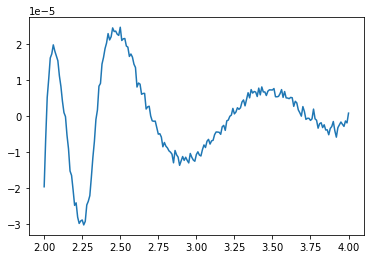

In [25]:
		p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
		yfit_poly = p12(x1log)
		yres_poly = (10.0**yfit_poly) - y1
		#plt.figure()
		#plt.grid()
		#plt.xlabel('Freq [MHz]')
		#plt.ylabel('res Temp [K]')
		#plt.plot(x1*1.0e3,yres_poly,lw=2)
        #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
		#plt.title('Polyo10 residual spec %s'%(i))
		# plt.show()
		#pdf.savefig()
		#plt.close()
		# Initial guess for optimization				
		p00 = [np.log10(3.0),1.0,-2.5] 
		
		p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		current_chisq = chisq1(p1,x1,y1)
		print (" ")
		print ("chisq1 = ",current_chisq)
		print (10.0**p1[0], p1[1], p1[2])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],0.0] 
		p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq2(p1,x1,y1)
		print (" ")
		print ("chisq2 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
		p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq3(p1,x1,y1)
		print (" ")
		print ("chisq3 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
		p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq4(p1,x1,y1)
		print (" ")
		print ("chisq4 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
		p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq5(p1,x1,y1)
		print (" ")
		print ("chisq5 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
		p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq6(p1,x1,y1)
		print (" ")
		print ("chisq6 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
		print (" ")

		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
		p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
		final_chisq = chisq7(p1,x1,y1)
		print (" ")
		print ("chisq7 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
		print (" ")
				
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
		p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq8(p1,x1,y1)
		print (" ")
		print ("chisq8 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])
		
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
		p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq9(p1,x1,y1)
		print (" ")
		print ("chisq9 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])
			
		p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
		p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
		final_chisq = chisq10(p1,x1,y1)
		print (" ")
		print ("chisq10 = ",final_chisq)
		print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
		print (" ")

# 		# p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],p1[11],0.0]
# 		# p1 = fmin(chisq11, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
# 		# final_chisq = chisq11(p1,x1,y1)
# 		# print " "
# 		# print "chisq11 = ",final_chisq
# 		# print 10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11],p1[12]
# 		# print " "

# 		# p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],p1[11],p1[12],0.0]
# 		# p1 = fmin(chisq12, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
# 		# final_chisq = chisq12(p1,x1,y1)
# 		# print " "
# 		# print "chisq12 = ",final_chisq
# 		# print 10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11],p1[12],p1[13]
# 		# print " "
# # Final plots in linear scale

# #		yfit = func12(p1,x1)

		yfit = func10(p1,x1)
		yres = y1 - yfit
		residuals.append(yres) 
		# scale = 0.03/chisq12(p1,x1,y1)
		# y2 = yfit + scale*(1.0e5**yres)
		yfitlog=np.log10(yfit)
#		y2log = np.log10(y2)
		
		# plt.figure()
		# plt.plot(x1,yfit,c='b')
		# plt.plot(x1,y2,linestyle='--',c='r')
		# plt.xlabel('Frequency (GHz)')
		# plt.ylabel('Antenna temperature (K)')
		# plt.show()						
		#plt.subplot(2,2,2*j+1)
		
		#plt.figure()
		#plt.grid()
		#plt.plot(x1*1.0e3,yres,lw=2,label='residual')
		#plt.xlabel('Frequency (MHz)')
		#plt.ylabel('Tdata - Tfit (K antenna temperature)')
		#plt.legend(loc='lower left')
		#plt.title('MSo10 residual %s'%(i))
		#plt.xlim([50.0,200.0])
		# plt.show()
		#pdf.savefig()
		#plt.close()
		#plt.subplot(2,2,2*j+2)
		# plt.figure()
		# plt.grid()
		# plt.plot(x1*1.0e3,y1,lw=2,label='data')
		# plt.plot(x1*1.0e3,yfit,lw=2,label='fit')
		# plt.legend(loc='upper right')
		# plt.title('Spec %s'%(i))
		# plt.xlim([40.0,200.0])
		# plt.show()
		#if (j == 1):
		# pdf.savefig()
		# plt.close()

residuals = np.asfarray(residuals)
print(residuals)

# np.savetxt(f_out,(residuals))
# with PdfPages('residuals_70_200_MHz_13apr16.pdf') as pdf:
# 	plt.figure()
# 	for i in range(0,np.shape(residuals)[0]):
# 		plt.plot(x1*1.0e3,residuals[i])
	
# plt.xlabel('Frequency [MHz]')
# plt.ylabel('res [K]')
# plt.grid()
# pdf.savefig()
# plt.close()

plt.plot(freqs, y1 - yfit)
plt.show()

### **Just checking the fitting functions**

##################################################
--------------------OPTIMUM RESULT--------------------
Time: 2.688133716583252
Polynomial Order: 14
Number of Constrained Derivatives: 12
Signs : [-1  1 -1  1 -1  1 -1  1 -1  1 -1  1]
Objective Function Value: 2.958612574774738e-08
Parameters: [[ 5.54999992e+02  5.45000015e+02  8.77645352e-06 -7.83231888e-06
   9.02493693e-06 -1.13169265e-05  1.29483929e-05 -1.21526350e-05
   8.87465783e-06 -4.87330797e-06  1.93843349e-06 -5.26859768e-07
   8.75570931e-08 -6.71593522e-09]]
Method: qp-sign_flipping
Model: difference_polynomial
Constraints: m >= 2
Zero Crossings Used? (0 signifies Yes
 in derivative order "i"): {'0': 1, '1': 1}
--------------------------------------------------
##################################################


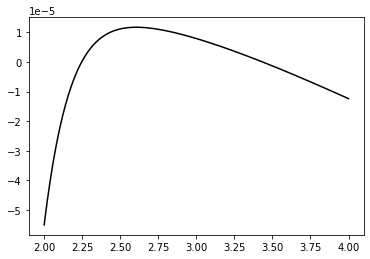

In [16]:
A = np.linspace(10,1100, No_of_Channels)
result = smooth((freqs), A, 14)
C = result.y_fit
plt.plot(freqs,(A-result.y_fit), color = 'black')

+------------------+--------------------+
|    Parameter     |       Value        |
+------------------+--------------------+
|       flag       |    201 elements    |
|      error       |    201 elements    |
|       xtol       |       1e-06        |
|       ftol       |       1e-06        |
|      domain      |      log_log       |
|     maxiter      |      100000.0      |
|      maxfev      |      100000.0      |
|       algo       |    Nelder-Mead     |
|      norder      |         8          |
|       temp       |        0.1         |
|     stepsize     |        0.1         |
|      niter       |         1          |
| basin_iter_loops |         10         |
|       xmin       |        2.0         |
|       xmax       |        4.0         |
|     rescale      |        True        |
|       seed       |         1          |
|     additive     |        True        |
|      joint       |       False        |
|      signal      |      [False]       |
|     add_ini      |        0.0   

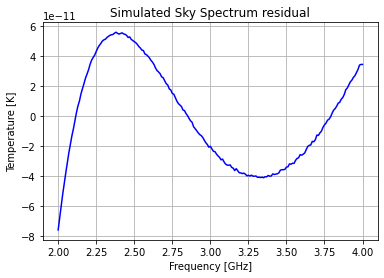

In [17]:
Res = (ms_fit_inf(freqs, A, norder = 8, domain='log_log'))
Res5 = Res[5]
Res5 = np.append(Res5, Res5[No_of_Channels - 2])

plt.plot(freqs, Res5, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
#plt.ylim([-0.0002,0.0006])
plt.show()

+------------------+--------------------+
|    Parameter     |       Value        |
+------------------+--------------------+
|       flag       |    201 elements    |
|      error       |    201 elements    |
|       xtol       |       1e-06        |
|       ftol       |       1e-06        |
|      domain      |      lin_lin       |
|     maxiter      |      100000.0      |
|      maxfev      |      100000.0      |
|       algo       |    Nelder-Mead     |
|      norder      |         8          |
|       temp       |        0.1         |
|     stepsize     |        0.1         |
|      niter       |         1          |
| basin_iter_loops |         10         |
|       xmin       |        2.0         |
|       xmax       |        4.0         |
|     rescale      |        True        |
|       seed       |         1          |
|     additive     |        True        |
|      joint       |       False        |
|      signal      |      [False]       |
|     add_ini      |        0.0   

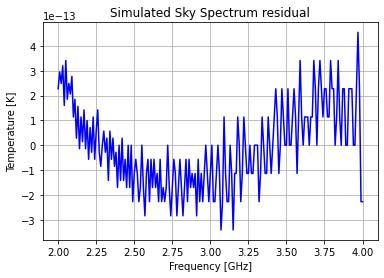

In [18]:
Res = (ms_fit_inf(freqs, A, norder = 8, domain='lin_lin'))
Res5 = Res[5]
Res5 = np.append(Res5, Res5[No_of_Channels - 2])

plt.plot(freqs, Res5, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
#plt.ylim([-0.0002,0.0006])
plt.show()

#### From the above, I feel MS_fit will work fine for our work, but not maxsmooth. 

+------------------+--------------------+
|    Parameter     |       Value        |
+------------------+--------------------+
|       flag       |    201 elements    |
|      error       |    201 elements    |
|       xtol       |       1e-06        |
|       ftol       |       1e-06        |
|      domain      |      lin_lin       |
|     maxiter      |      100000.0      |
|      maxfev      |      100000.0      |
|       algo       |    Nelder-Mead     |
|      norder      |         8          |
|       temp       |        0.1         |
|     stepsize     |        0.1         |
|      niter       |         1          |
| basin_iter_loops |         10         |
|       xmin       |        2.0         |
|       xmax       |        4.0         |
|     rescale      |        True        |
|       seed       |         1          |
|     additive     |        True        |
|      joint       |       False        |
|      signal      |      [False]       |
|     add_ini      |        0.0   

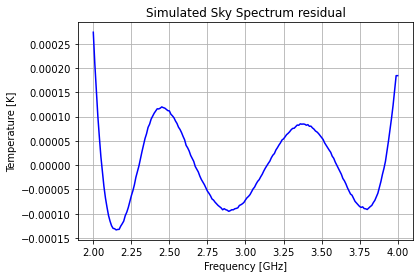

In [20]:
Res = (ms_fit_inf(freqs, spectra[0], norder = 8, domain='lin_lin'))
Res5 = Res[5]
Res5 = np.append(Res5, Res5[No_of_Channels - 2])

plt.plot(freqs, Res5, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
#plt.ylim([-0.0002,0.0006])
plt.show()

### **Checking the Rec int final temp alone**

No. of spectra got =  1
No. of spectra got =  2
No. of spectra got =  3
No. of spectra got =  4
No. of spectra got =  5


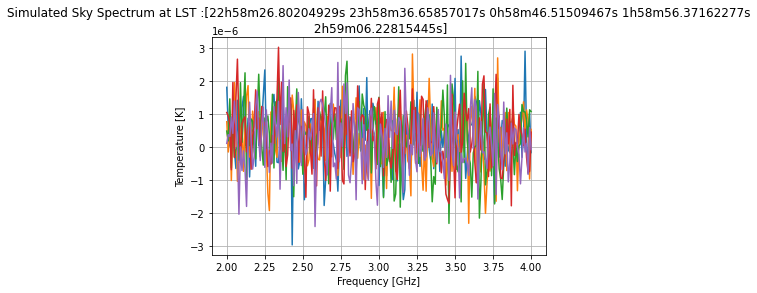

In [26]:
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels

k = 0
while k<n_spectra:
    i=1
    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[k], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
    
    
    
        j=0
        while j< No_of_Channels:
            cwt = beam_def(freqs[j],equi.az.value, new_alt)
        
            if (cwt>0):     #Adding all 3 intensities
                Power = Rec_int[j]
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
                cross_real[j] = cross_real[j] + cwt*final_temp
                sumwt[j] = sumwt[j]+ cwt
            
            j = j+1
        
        
        i = i+1

    
    i=0    
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        
    sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)    
    array = np.random.normal(0,1,No_of_Channels)

    cross_real = cross_real + array*sigma
    cross_imag = cross_imag + array*sigma
    
    spectra[k] = cross_real
    spectra_cross_imag[k] = cross_imag
    
    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = [0]*No_of_Channels
    
    print("No. of spectra got = ", k+1)
    
    k = k+1

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
    

i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()




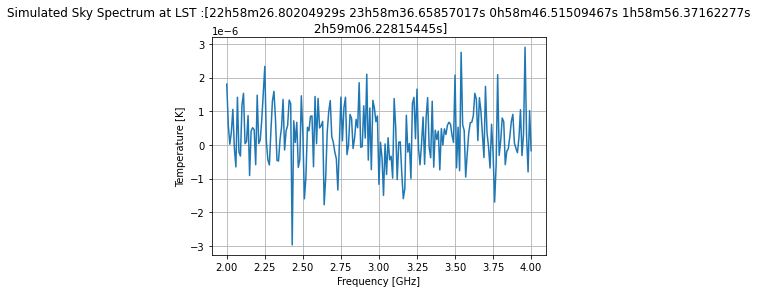

In [30]:
plt.plot(freqs, spectra[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()

In [31]:
# I think there is something wrong with the rec int temp calculation, as it gives only microK, but we expect it in nanoK